# Рекомендательная система фильмов

---
**Цель**: Построить рекомендательную систему, которая будет предлагать пользователю список из *n* самых интересных для него фильмов. 
___
**Задачи**: 

1. Обработать данные.
2. Реализовать систему извлечения пула фильмов из которых будут выбираться *n* самых интересных.
3. Построить алгоритм матричного разложения для предсказания значения оценки.
4. Протестировать модель.
---

## Про датасет

Датасет взят с kaggle (https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset#). Он был собран GroupLens Research Project с сайта **MovieLens**. Он содержит данные о 100,000 рейтингах от 943 пользователей на 1682 фильмах. Также представлена простая демографическая информация о пользователях (возраст, пол, должность, почтовый индекс).

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872

## Источники

1. Kaggle (https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset#).
2. Учебник по машинному обучению от ШАДа (https://education.yandex.ru/handbook/ml).

## Метод решения. Структура системы.

&emsp;Для предсказаний рейтинга я собираюсь использовать метод матричной факторизации с Alternate Least Squares (ALS). 

&emsp;Однако, так как задача восстановления всех латентных представлений в матрице 941x1682 довольно затратна и, к тому же так как нам не к чему рассматривать все возможные айтемы, а достаточно каким либо образом выбрать пул, айтемы из которого с наибольшей вероятностью могут понравиться пользователю, я решил добавить шаг извлечения кандидатов. Я буду искать k наиболее релевантных фильмов с помощью приближенного метода Hierarchial navigable small world (HNSW).

&emsp;Но для корректной работы KNN нужно представить фичи фильмов таким образом, чтобы они могли отражать меру расстояния или схожести между объектами. Так как нет понятного способа рассчитать расстояние между мужчиной и женщиной, или между двумя должностями, я решил использовать обучение представлений на основе triplet loss. 

&emsp;В итоге получается структура схематично изображенная на рисунке ниже.  

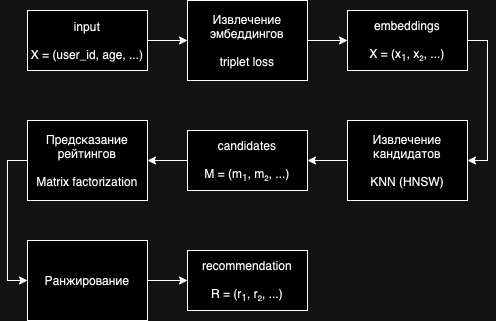

## Embedding retrieving

In [1]:
# Импорт билиотек
import pandas as pd
import numpy as np
import torch
import random
import hnswlib
from sklearn.preprocessing import StandardScaler

In [2]:
import pandas as pd

# Загрузка данных
ratings = pd.read_csv("ml-100k/u.data", sep='\t', header=None)
ratings.columns = ["user_id", "movie_id", "rating", "timestamp"]
ratings = ratings.drop(["timestamp"], axis=1)

movies = pd.read_csv("ml-100k/u.item", encoding='latin-1', header=None, sep='|')
movies.columns = ["movie_id", "movie_title", "release_date", "video_release_date",
              "IMDb_URL", "unknown", "Action", "Adventure", "Animation",
              "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
              "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
              "Thriller", "War", "Western"]
movies["release_date"] = pd.to_datetime(movies['release_date']).dt.year
movies = movies.drop(["IMDb_URL", "video_release_date", "movie_title"], axis=1)

# Объединение данных
data = pd.merge(ratings, movies, on='movie_id')

data.head()

,user_id,movie_id,rating,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,1997.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,1997.0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,1994.0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,1994.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,1997.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def generate_triplets(data: pd.DataFrame):
    triplets = []

    grouped_data = data.groupby('user_id')
    for user_id, user_ratings in grouped_data:
        positive_items = user_ratings[user_ratings['rating'] >= 4]['movie_id'].to_list()
        negative_items = user_ratings[user_ratings['rating'] <= 2]['movie_id'].to_list()
    
    if len(positive_items) > 1 and len(negative_items) > 0:
        for anchor in positive_items:
            positive = random.choice(positive_items)
            negative = random.choice(negative_items)
            triplets.append((anchor, positive, negative))
    
    return triplets

In [4]:
class MovieEmbedding(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim=32):
        super(MovieEmbedding, self).__init__()

        # fc - fully connected layer
        self.fc1 = torch.nn.Linear(input_dim, 64)
        self.fc2 = torch.nn.Linear(64, embedding_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
class MovieTripletData(torch.utils.data.Dataset):
    def __init__(self, triplets, item_features):
        self.triplets = triplets
        self.item_features = item_features.set_index('movie_id')

    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, index):
        anchor, positive, negative = self.triplets[index]

        anchor_features = self.item_features.loc[anchor].values
        positive_features = self.item_features.loc[positive].values
        negative_features = self.item_features.loc[negative].values

        return (torch.tensor(anchor_features, dtype=torch.float32),
                torch.tensor(positive_features, dtype=torch.float32),
                torch.tensor(negative_features, dtype=torch.float32))

In [6]:
movies_features = movies[["movie_id", "release_date",
                "unknown", "Action", "Adventure", "Animation",
                "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
                "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
                "Thriller", "War", "Western"]]

scaler = StandardScaler()
movies_features['release_date'] = scaler.fit_transform(movies_features[['release_date']])

input_dim = movies_features.shape[1] - 1 # -1 for movie_id
embedding_dim = 32
model = MovieEmbedding(input_dim=input_dim, embedding_dim=embedding_dim)

triplets = generate_triplets(data=data)
triplets_data = MovieTripletData(triplets=triplets, item_features=movies_features)
train_loader = torch.utils.data.DataLoader(triplets_data, batch_size=32, shuffle=True)

triplet_loss = torch.nn.TripletMarginLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
model.train()
epochs = 10
for epoch in range(epochs):
    epoch_loss = 0
    for anchor, positive, negative in train_loader:
        anchor_embedding = model(anchor)
        positive_embedding = model(positive)
        negative_embedding = model(negative)

        loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader)}")

Epoch 1/10, Loss: 0.9887134631474813
Epoch 2/10, Loss: 0.9633578459421793
Epoch 3/10, Loss: 0.9396054347356161
Epoch 4/10, Loss: 0.915859580039978
Epoch 5/10, Loss: 0.8929341634114584
Epoch 6/10, Loss: 0.8703547120094299
Epoch 7/10, Loss: 0.8473304510116577
Epoch 8/10, Loss: 0.825558582941691
Epoch 9/10, Loss: 0.8014630277951559
Epoch 10/10, Loss: 0.7786126136779785


In [8]:
def get_embedding(movie_id, movies_features):
    return model(torch.tensor(movies_features.set_index("movie_id").loc[movie_id].values, dtype=torch.float32))

In [9]:
def process_data_to_embedding(movies_features):
    embeddings = []
    for movie_id in movies_features["movie_id"]:
        embeddings.append(get_embedding(movie_id, movies_features).detach().numpy())
    return np.array(embeddings)

In [10]:
def set_hnsw(embeddings, embedding_dim, ef_construction=200, M=16):
    num_elements = embeddings.shape[0]
    hnsw_index = hnswlib.Index(space='cosine', dim=embedding_dim)
    hnsw_index.init_index(max_elements=num_elements, ef_construction=ef_construction, M=M)
    hnsw_index.add_items(embeddings)
    hnsw_index.set_ef(50)

    return hnsw_index

In [11]:
def query_hnsw_index(hnsw_index, item_id, k):
    print(item_id)
    labels, distances = hnsw_index.knn_query([item_id], k=k)
    return labels, distances

In [12]:
embeddings = process_data_to_embedding(movies_features)
hnsw_index = set_hnsw(embeddings, 32)
query_hnsw_index(hnsw_index, 242, 10)

242


(array([[ 55,  63,  99, 181, 281, 284, 286, 328, 347, 377]], dtype=uint64),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32))